In [1]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### 查看股票数据

In [2]:
def stocks_data(symbols,dates):
    df=pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp=pd.read_csv("D:/Code/Ipynb/Pytorch/Homework/data/Stock/{}.us.txt".format(symbol),
                            index_col='Date',
                            parse_dates=True,
                            usecols=['Date','Close'],
                            na_values=['nan'])
        df_temp=df_temp.rename(columns={'Close':symbol})
        df=df.join(df_temp)
    return df

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F46C1F550>,
      dtype=object)

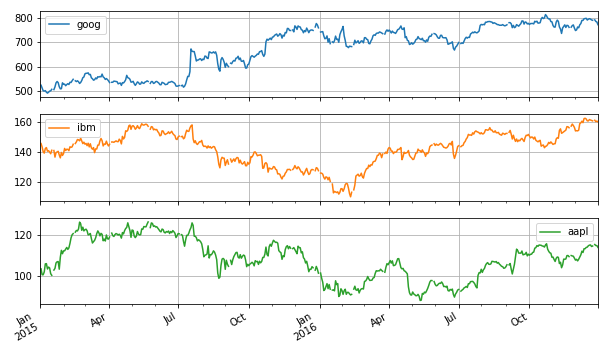

In [3]:
dates=pd.date_range('2015-01-01','2016-12-31',freq='B')#每个工作日记录
symbols=['goog','ibm','aapl']
df = stocks_data(symbols,dates)

df.fillna(method='ffill')#nan填充
df.plot(figsize=(10,6),grid=True,subplots=True)

#### 构造实验数据集

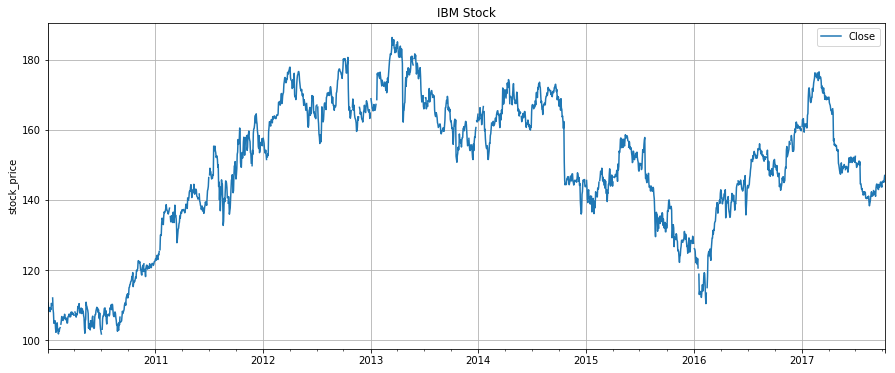

In [4]:
dates=pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("D:/Code/Ipynb/Pytorch/Homework/data/Stock/ibm.us.txt",
                            index_col=0,
                            parse_dates=True)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15,6))
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.grid()
plt.show()

##### 查看原始数据

In [5]:
df_ibm
print("{:=^50s}".format("查看df_ibm的前面五条数据"))
print(df_ibm.head())
print("{:=^50s}".format("查看df_ibm的简要信息"))
print(df_ibm.info())

=================查看df_ibm的前面五条数据==================
              Open    High     Low   Close     Volume  OpenInt
2010-01-04  109.55  111.03  109.26  110.59  7371472.0      0.0
2010-01-05  109.95  110.11  108.65  109.26  8193158.0      0.0
2010-01-06  109.12  109.81  108.39  108.56  6712810.0      0.0
2010-01-07  108.45  108.77  107.65  108.19  6995459.0      0.0
2010-01-08  107.76  109.31  107.75  109.26  5019238.0      0.0
==================查看df_ibm的简要信息===================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     1958 non-null   float64
 1   High     1958 non-null   float64
 2   Low      1958 non-null   float64
 3   Close    1958 non-null   float64
 4   Volume   1958 non-null   float64
 5   OpenInt  1958 non-null   float64
dtypes: float64(6)
memory usage: 190.9 KB
None


In [6]:
df_ibm=df_ibm[['Close']] #选取Close列
print("{:=^50s}".format("查看df_ibm的前面五条数据"))
print(df_ibm.head())
print("{:=^50s}".format("查看df_ibm的简要信息"))
print(df_ibm.info())

=================查看df_ibm的前面五条数据==================
             Close
2010-01-04  110.59
2010-01-05  109.26
2010-01-06  108.56
2010-01-07  108.19
2010-01-08  109.26
==================查看df_ibm的简要信息===================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 111.7 KB
None


In [7]:
#填充空值
df_ibm=df_ibm.fillna(method='ffill')
print("{:=^50s}".format("查看df_ibm的前面五条数据"))
print(df_ibm.head())
print("{:=^50s}".format("查看df_ibm的简要信息"))
print(df_ibm.info())

=================查看df_ibm的前面五条数据==================
             Close
2010-01-04  110.59
2010-01-05  109.26
2010-01-06  108.56
2010-01-07  108.19
2010-01-08  109.26
==================查看df_ibm的简要信息===================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2028 non-null   float64
dtypes: float64(1)
memory usage: 111.7 KB
None


In [8]:
#对数据进行归一化
scaler=MinMaxScaler(feature_range=(-1,1))
df_ibm['Close']=scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
df_ibm.head()

,Close
2010-01-04,-0.790830
2010-01-05,-0.822264
2010-01-06,-0.838809
2010-01-07,-0.847554
2010-01-08,-0.822264


#### 训练集、测试集划分

In [9]:
def load_data(stock,look_back):
    data_raw = stock.values #numpy array类型
    data = []
    for index in range(len(data_raw)-look_back):
        #从data_raw中截取长度为look_back的数据
        data.append(data_raw[index:index+look_back]) #使用list拼接数据集
    data = np.array(data) #shape:(1968,60,1) #再转化为numpy array类型
    #Close列一共有1968行，每隔60个数据点取一个样本，前59个数据点作为输入后一个作为输出
    
    test_set_size=int(np.round(0.2*data.shape[0])) #测试集占data的20%
    train_set_size=data.shape[0]-(test_set_size)
    
    x_train=torch.Tensor(data[:train_set_size,:-1,:]) #转化为张量
    y_train=torch.Tensor(data[:train_set_size,-1,:])
    x_test=torch.Tensor(data[train_set_size:,:-1,:])
    y_test=torch.Tensor(data[train_set_size:,-1,:])
    return [x_train,y_train,x_test,y_test]

In [10]:
x_train,y_train,x_test,y_test=load_data(df_ibm,look_back=60)

#### 定义RNN模型
nn.RNN(input_size, hidden_size, num_layers=1, nonlinearity=tanh, bias=True, batch_first=False, dropout=0, bidirectional=False)
- **input_size**:输入特征的维度， 一般rnn中输入的是词向量，那么 input_size 就等于一个词向量的维度
- **hidden_size**:隐藏层神经元个数，或者也叫输出的维度（因为rnn输出为各个时间步上的隐藏状态）
- **num_layers**:网络的层数
- nonlinearity:激活函数
- bias:是否使用偏置
- batch_first:输入数据的形式，默认是 False，就是这样形式，(seq(num_step), batch, input_dim)，也就是将序列长度放在第一位，batch 放在第二位
- dropout:是否应用dropout, 默认不使用，如若使用将其设置成一个0-1的数字即可
- birdirectional:是否使用双向的 rnn，默认是 False

In [11]:
class RNN(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(RNN,self).__init__()
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_dim=output_dim
        
        self.rnn=nn.RNN(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        out,hn=self.rnn(x,h0.detach())
        #hn：隐藏状态，hidden state 
        out=self.fc(out[:,-1,:])
        return out

In [13]:
rnn_model=RNN(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(),lr=0.01)

#### 训练模型

In [14]:
num_epochs=200
hist=np.zeros(num_epochs)
print("RNN's training:")
for t in range(num_epochs):
    y_train_pred=rnn_model(x_train)
    loss=loss_fn(y_train_pred,y_train)
    if t%10==0 and t!=0:
        print("Epoch:",t,"MSE:{}".format(loss.item()))
    hist[t]=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 10 MSE:0.025544462725520134
Epoch: 20 MSE:0.011062566190958023
Epoch: 30 MSE:0.004748199135065079
Epoch: 40 MSE:0.002644042717292905
Epoch: 50 MSE:0.0022663960698992014
Epoch: 60 MSE:0.002181397983804345
Epoch: 70 MSE:0.0021175758447498083
Epoch: 80 MSE:0.0020633279345929623
Epoch: 90 MSE:0.0020203262101858854
Epoch: 100 MSE:0.001982147805392742
Epoch: 110 MSE:0.0019485756056383252
Epoch: 120 MSE:0.0019212407059967518
Epoch: 130 MSE:0.0018985435599461198
Epoch: 140 MSE:0.0018792232731357217
Epoch: 150 MSE:0.0018630867125466466
Epoch: 160 MSE:0.001849569845944643
Epoch: 170 MSE:0.0018383454298600554
Epoch: 180 MSE:0.0018290679436177015
Epoch: 190 MSE:0.0018214426236227155


##### 绘制损失函数图像

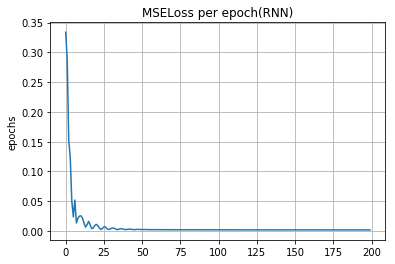

In [15]:
plt.plot(range(num_epochs),hist[range(num_epochs)])
plt.ylabel("epochs")
plt.title("MSELoss per epoch(RNN)")
plt.grid()
plt.show()

#### 查看股票预测结果

In [16]:
y_test_pred = rnn_model(x_test) # 对测试数据执行预测

# 对数据进行反归一化，同时转化为 numpy 的数据格式
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

##### 预测结果可视化

d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


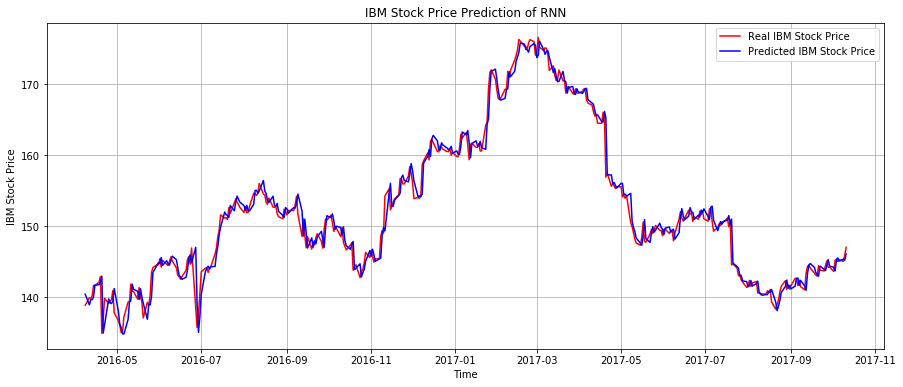

In [17]:
figure,axes = plt.subplots(figsize=(15,6))
axes.xaxis_date()
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red',
          label = 'Real IBM Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue',
          label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction of RNN')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.grid()
plt.show()